In [33]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb 
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import datetime

Read Data

In [22]:
df = pd.read_csv("../data/raw/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [23]:
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [30]:
df.index.dtype

dtype('O')

In [35]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [36]:
df.index = pd.to_datetime(df.index)

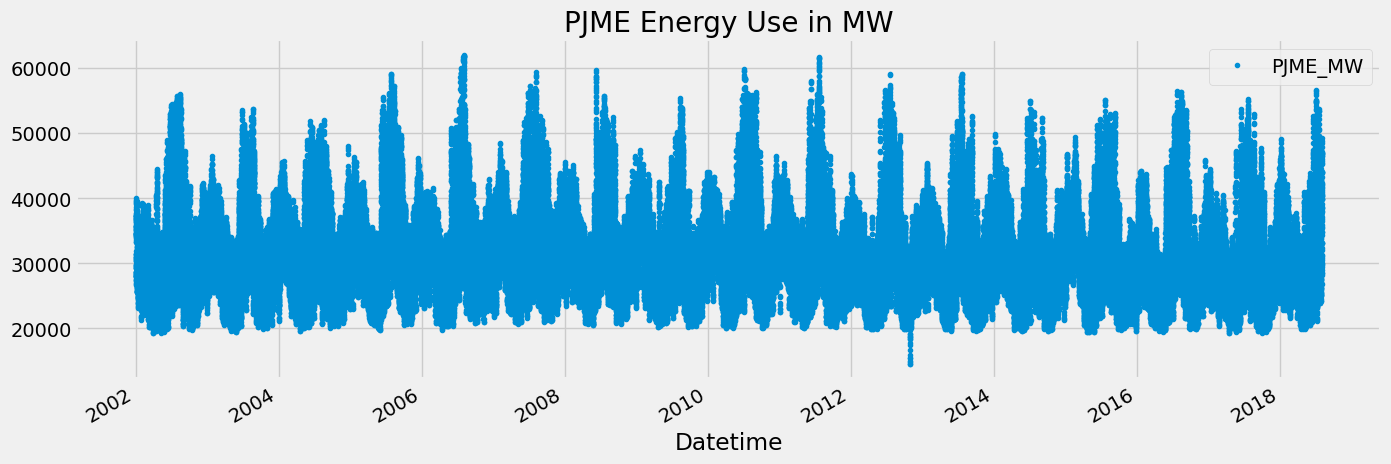

In [43]:
df.plot(style=".", figsize=(15,5), color = color_pal[0], title="PJME Energy Use in MW")
plt.show()

Outlier Detection

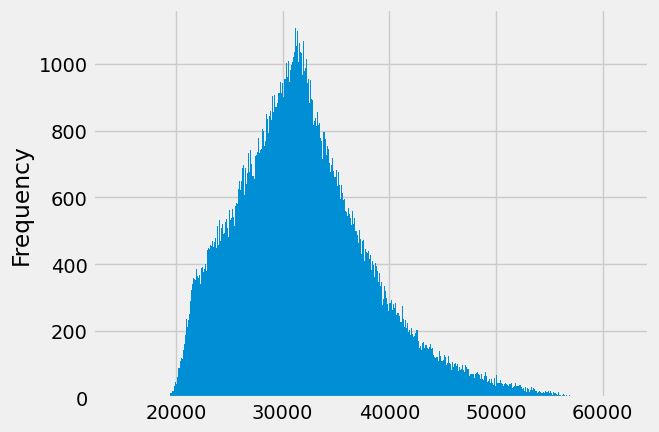

In [49]:
df["PJME_MW"].plot(kind="hist", bins=500)
plt.show()

<Axes: title={'center': 'Outliers Investigation'}, xlabel='Datetime'>

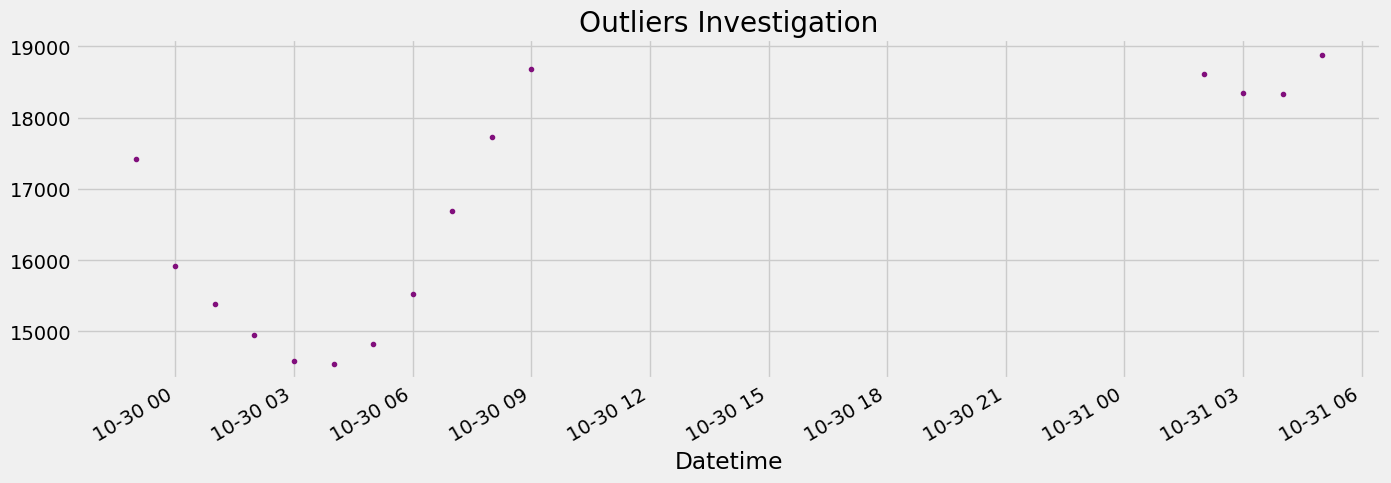

In [66]:
(df.query("PJME_MW < 19_000")["PJME_MW"]).plot(style=".", figsize=(15,5), color= color_pal[5], title="Outliers Investigation")

Remove outliers

In [69]:
df = df.query("PJME_MW > 19_000").copy()

ML: Split Data

In [72]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

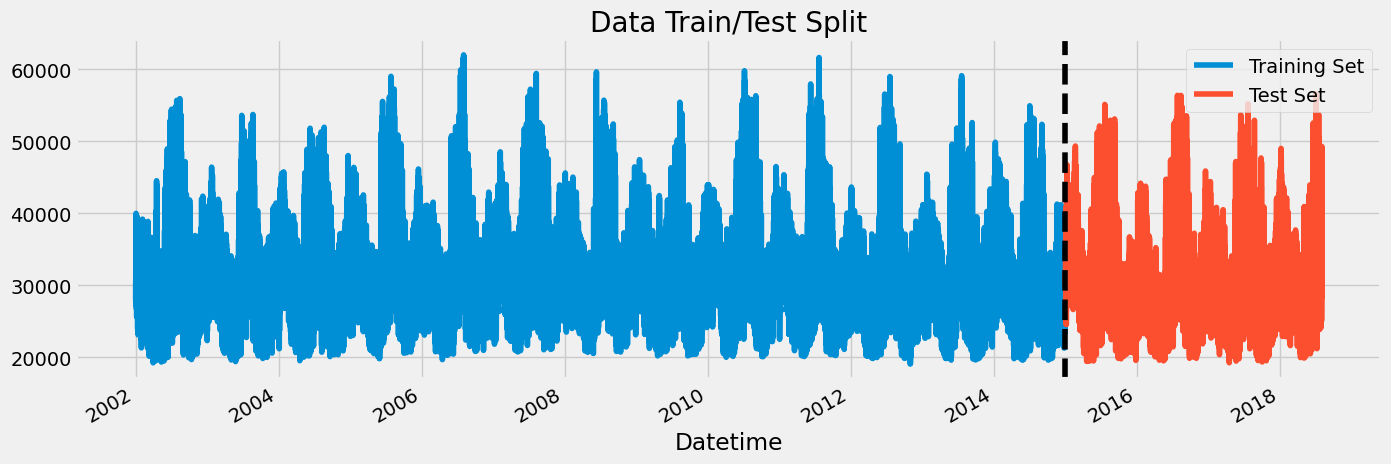

In [80]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")

ax.axvline("01-01-2015", color="black", ls= "--")
ax.legend(["Training Set", "Test Set"])
plt.show()

Time Series Cross Validation

In [82]:
from sklearn.model_selection import TimeSeriesSplit


tss = TimeSeriesSplit(n_splits=5, test_size= 24*365*1, gap=24)
df = df.sort_index()

In [ ]:
fig, axe = plt.subplots(5,1,figsize=(15,15), sharedx=True)


fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]